# Generación del Dataset $(\phi, r_0) \rightarrow u(\phi)$

El dataset se genera utilizando funciones que describen órbitas en el caso crítico ($b = b_{\text{crit}}$). Las entradas son el ángulo $\phi$ y el parámetro $r_0$ (radio inicial), y la salida es $u(\phi) = 1/r(\phi)$.

Las unidades geométricas están escaladas por $r_s = 1$. El radio crítico es $r_{\text{crit}} = 1.5 r_s = 1.5$.

La relación entre $r_0$ y el ángulo $\alpha$ se da por:
$$ \alpha = -2 \text{atanh}\left( \frac{1}{\sqrt{r_0 + \frac{1}{3}}} \right) $$

La función $u(\phi) = 1/r(\phi)$ se define a partir de la relación entre $r$ y $\phi$:
$$ r = \frac{1}{\tanh^2\left(\frac{\phi - \alpha}{2}\right)} - \frac{1}{3} \quad \text{(para } r_0 < r_{\text{crit}}, \text{rama IN)} $$
$$ r = \frac{1}{\left(\frac{1}{\tanh\left(\frac{\phi - \alpha}{2}\right)}\right)^2} - \frac{1}{3} \quad \text{(para } r_0 > r_{\text{crit}}, \text{rama OUT)} $$

Se generan muestras de $r_0$ tanto en la rama IN ($1.01 \le r_0 \le 1.49$) como en la rama OUT ($1.51 \le r_0 \le 40.0$). Para cada valor de $r_0$, se evalúa $u(\phi)$ en un rango de valores de $\phi$ ($0.005 \le \phi \le 8.0$). Se descartan los puntos no físicos donde $u(\phi)$ no es finito o positivo.

In [1]:
# ================== Generador dataset (phi, r0) -> u(phi) ==================
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Unidades geométricas
rs = 1.0
rcrit = 1.5 * rs   # 3 rs / 2
phi_vals = np.linspace(0.005, 8.0, 1000).astype(np.float32)

def alpha_from_r0(r0):
    # alpha = -2 * atanh( 1 / sqrt(r0 + 1/3) )
    return -2.0 * np.arctanh(1.0 / np.sqrt(r0 + 1.0/3.0))

def u_from_phi_r0(phi, r0):
    """
    Devuelve u(phi) = 1/r(phi) para el caso crítico (b = b_crit),
    usando la rama in/out según r0.
    """
    alpha = alpha_from_r0(r0)
    x = (phi - alpha) / 2.0
    if r0 < rcrit:   # IN: r in (rs, 3rs/2) -> tanh
        r = 1.0 / np.tanh(x)**2 - 1.0/3.0
    else:            # OUT: r > 3rs/2 -> coth = 1/tanh
        r = 1.0 / (1.0/np.tanh(x))**2 - 1.0/3.0
    u = 1.0 / r
    return u.astype(np.float32)

# Muestras de r0: in (1.01..1.49), out (1.51..50)
rng = np.random.default_rng(123)
r0_in  = rng.uniform(1.01, 1.49, size=25).astype(np.float32)
r0_out = rng.uniform(1.51, 40.0, size=25).astype(np.float32)
r0_all = np.concatenate([r0_in, r0_out])  # 50 condiciones

# Construcción del dataset “denso” (todas las φ para cada r0)
rows = []
for r0 in r0_all:
    u_vals = u_from_phi_r0(phi_vals, r0)
    # descarta puntos no físicos (por robustez)
    mask = np.isfinite(u_vals) & (u_vals > 0)
    for phi, u in zip(phi_vals[mask], u_vals[mask]):
        rows.append([phi, r0, u])

dataset_np = np.array(rows, dtype=np.float32)  # columnas: [phi, r0, u]
print("Dataset:", dataset_np.shape)


Dataset: (47682, 3)


# Preprocesamiento

Se extraen las columnas $\phi$, $r_0$ y $u$ del dataset. Se aplica una máscara para asegurar que los valores sean finitos y $u$ sea positivo.

**Inputs:**
* $\phi$: Se aplica *z-score* normalización.
* $r_0$: Se aplica $\log(1+r_0)$ seguido de *z-score* normalización para manejar la amplia dinámica en la rama OUT.

Los inputs normalizados se concatenan para formar la matriz de features $X$.

**Target:**
* $u$: Se aplica $\log(u)$ para el target $y$, después de aplicar un clip para evitar $\log(0)$.

**Split:**
Los datos se dividen en conjuntos de entrenamiento (80%) y validación (20%) de forma aleatoria.

**DataLoaders:**
Se crean `TensorDataset` y `DataLoader`s de PyTorch para el entrenamiento y validación, con tamaños de batch de 256 y 512 respectivamente.

In [2]:

# -----------------------------
# PREPROCESAMIENTO
# -----------------------------
phi = dataset_np[:, 0:1]
r0  = dataset_np[:, 1:2]
u   = dataset_np[:, 2:3]

# Seguridad por si queda algo raro:
mask = np.isfinite(phi).ravel() & np.isfinite(r0).ravel() & np.isfinite(u).ravel() & (u.ravel() > 0)
phi, r0, u = phi[mask], r0[mask], u[mask]

# --- Inputs (todo numérico) ---
# z-score en φ
phi_mean, phi_std = phi.mean(), phi.std() + 1e-8
phi_n = (phi - phi_mean) / phi_std

# r0 tiene dinámica muy amplia en OUT; aplicar log1p y z-score
r0_log = np.log1p(r0)  # estabiliza escala
r0_mean, r0_std = r0_log.mean(), r0_log.std() + 1e-8
r0_n = (r0_log - r0_mean) / r0_std

X = np.concatenate([phi_n, r0_n], axis=1).astype(np.float32)  # (N,2)

# --- Target: y = log(u) ---
u_clip = np.clip(u, 1e-8, None)          # evitar log(0)
y = np.log(u_clip).astype(np.float32)    # (N,1)

# Split train/valid
rng = np.random.default_rng(42)
idx = np.arange(X.shape[0]); rng.shuffle(idx)
n_tr = int(0.8 * len(idx))
i_tr, i_va = idx[:n_tr], idx[n_tr:]
Xtr, ytr = X[i_tr], y[i_tr]
Xva, yva = X[i_va], y[i_va]

# Tensores y loaders
Xtr_t = torch.tensor(Xtr); ytr_t = torch.tensor(ytr)
Xva_t = torch.tensor(Xva); yva_t = torch.tensor(yva)
train_loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)
valid_loader = DataLoader(TensorDataset(Xva_t, yva_t), batch_size=512, shuffle=False)


# Modelo (2 $\rightarrow$ 1) + Entrenamiento

Se define un modelo de red neuronal simple (`OrbitNet2`) con dos capas ocultas utilizando la función de activación $\tanh$. La arquitectura es:
$$ \text{Input (2)} \rightarrow \text{Linear (128)} \rightarrow \tanh \rightarrow \text{Linear (128)} \rightarrow \tanh \rightarrow \text{Linear (1)} \rightarrow \text{Output (1)} $$

El modelo se entrena para 200 épocas utilizando el optimizador Adam con una tasa de aprendizaje de $10^{-3}$. La función de pérdida utilizada es el Error Cuadrático Medio ($\text{MSE}$), que se calcula sobre el $\log(u)$ predicho y real.

Durante el entrenamiento, se calcula y registra el $\text{MSE}$ en los conjuntos de entrenamiento y validación al final de cada época. Se utiliza una barra de progreso (`tqdm`) para visualizar el avance del entrenamiento.

Finalmente, se grafica la curva de aprendizaje, mostrando el $\text{MSE}$ en función de la época para los conjuntos de entrenamiento y validación.

/usr/local/lib/python3.12/dist-packages/tqdm/std.py:161: TqdmWarning: Unknown colour (teal); valid choices: [hex (#00ff00), BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE]
  self.colour = colour
Entrenando: 100%|██████████| 200/200 [01:53<00:00,  1.76it/s, MSE_tr=0.002721, MSE_val=0.002207]


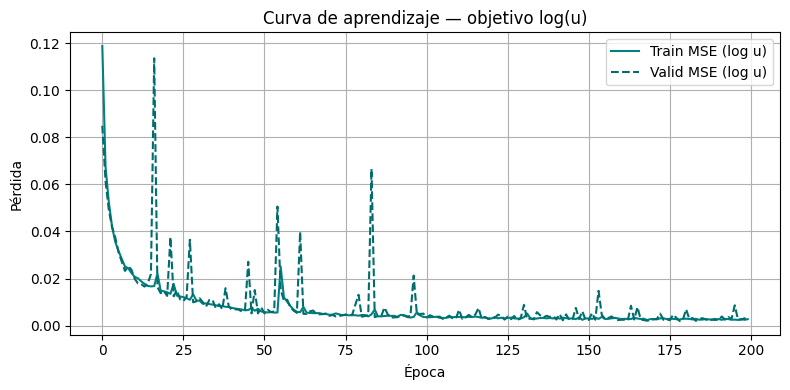

In [3]:

# -----------------------------
# MODELO (2 -> 1) + ENTRENAMIENTO
# -----------------------------
class OrbitNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
        )
    def forward(self, x): return self.net(x)

model = OrbitNet2()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

epochs = 200
tr_losses, va_losses = [], []
pbar = tqdm(range(epochs), desc="Entrenando", colour="teal")
for _ in pbar:
    model.train()
    tr = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        tr += loss.item() * xb.size(0)
    tr /= len(train_loader.dataset)

    model.eval()
    va = 0.0
    with torch.no_grad():
        for xb, yb in valid_loader:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            va += loss.item() * xb.size(0)
    va /= len(valid_loader.dataset)

    tr_losses.append(tr); va_losses.append(va)
    pbar.set_postfix({"MSE_tr": f"{tr:.6f}", "MSE_val": f"{va:.6f}"})

# Curva de aprendizaje (MSE en log u)
plt.figure(figsize=(8,4))
plt.plot(tr_losses, label="Train MSE (log u)", color="#008080")
plt.plot(va_losses, label="Valid MSE (log u)", linestyle="--", color="#006d6d")
plt.xlabel("Época"); plt.ylabel("Pérdida"); plt.title("Curva de aprendizaje — objetivo log(u)")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# Evaluación: deshacer log para comparar en u y en (x,y)

Después de entrenar el modelo, se evalúa su rendimiento comparando las predicciones con los valores reales. Para ello, se deshace la transformación logarítmica aplicada al target, obteniendo así las predicciones de $u$.

Se utilizan las utilidades originales para generar los valores reales de $u$ y las coordenadas cartesianas $(x, y)$.

Se seleccionan dos casos de prueba representativos: una órbita IN ($r_0=1.2$) y una órbita OUT ($r_0=3.0$).

Para cada caso de prueba, se realizan las siguientes comparaciones:
* Gráfico de $u(\phi)$ real vs. predicho.
* Gráfico de la órbita cartesiana $(x, y)$ real vs. predicha.

Estas visualizaciones permiten evaluar visualmente la capacidad del modelo para reproducir las órbitas generadas sintéticamente.

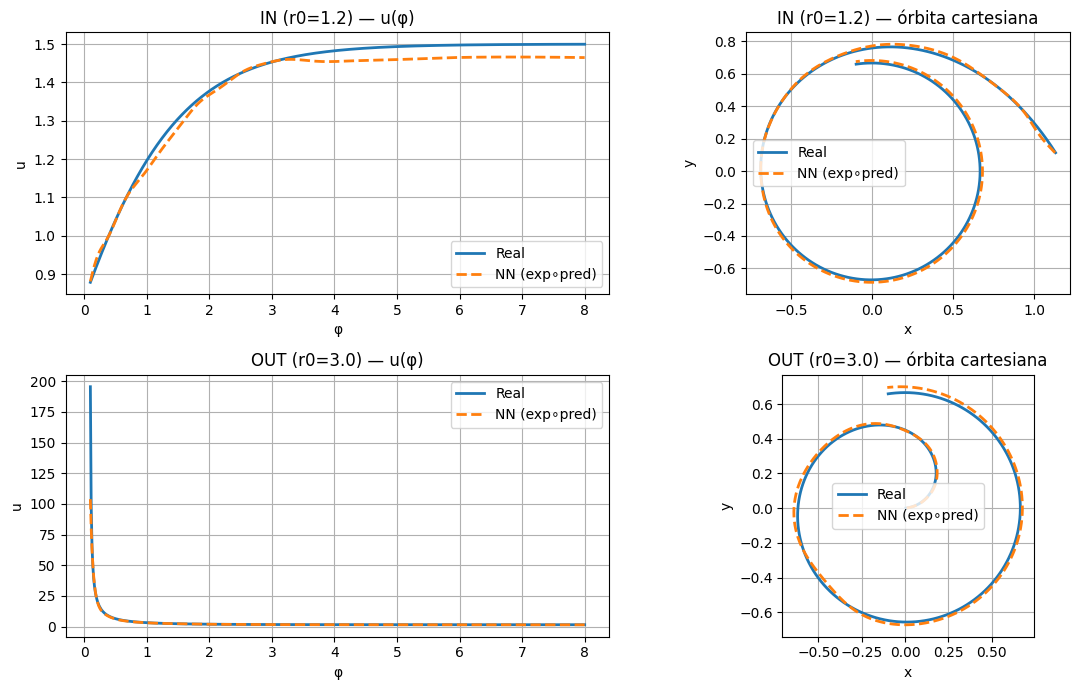

In [4]:

# -----------------------------
# EVALUACIÓN: deshacer log para comparar en u y en (x,y)
# -----------------------------
# Utilidades coherentes con el generador original:
rs = 1.0
rcrit = 1.5 * rs
def alpha_from_r0(r0):
    return -2.0 * np.arctanh(1.0 / np.sqrt(r0 + 1.0/3.0))

def u_from_phi_r0(phi, r0):
    alpha = alpha_from_r0(r0)
    x = (phi - alpha) / 2.0
    if r0 < rcrit:   # IN
        r = 1.0 / np.tanh(x)**2 - 1.0/3.0
    else:            # OUT
        r = 1.0 / (1.0/np.tanh(x))**2 - 1.0/3.0
    return (1.0 / r).astype(np.float32)

def prep_X(phi_array, r0_value):
    phi_array = np.asarray(phi_array, dtype=np.float32).reshape(-1,1)
    r0_array  = np.full_like(phi_array, r0_value, dtype=np.float32)
    phi_n = (phi_array - phi_mean) / phi_std
    r0_n  = (np.log1p(r0_array) - r0_mean) / r0_std
    X_eval = np.concatenate([phi_n, r0_n], axis=1).astype(np.float32)
    return torch.tensor(X_eval, dtype=torch.float32)

phi_plot = np.linspace(0.1, 8.0, 600).astype(np.float32)

tests = [
    ("IN (r0=1.2)", 1.2),   # in-spiraling
    ("OUT (r0=3.0)", 3.0),  # out-spiraling
]

fig, axes = plt.subplots(len(tests), 2, figsize=(12, 7))
if len(tests) == 1: axes = np.array([axes])

for i, (label, r0val) in enumerate(tests):
    # Real
    u_true = u_from_phi_r0(phi_plot, r0val)
    r_true = 1.0 / np.clip(u_true, 1e-10, None)
    x_true, y_true = r_true * np.cos(phi_plot), r_true * np.sin(phi_plot)

    # Predicción (recordar: la red produce log(u))
    X_eval = prep_X(phi_plot, r0val)
    model.eval()
    with torch.no_grad():
        y_pred_log = model(X_eval).squeeze(-1).cpu().numpy()  # ~ log(u)
    u_pred = np.exp(y_pred_log)                               # deshacer log
    r_pred = 1.0 / np.clip(u_pred, 1e-10, None)
    x_pred, y_pred = r_pred * np.cos(phi_plot), r_pred * np.sin(phi_plot)

    # u(φ)
    axes[i, 0].plot(phi_plot, u_true, label="Real", lw=2)
    axes[i, 0].plot(phi_plot, u_pred, '--', label="NN (exp∘pred)", lw=2)
    axes[i, 0].set_title(f"{label} — u(φ)")
    axes[i, 0].set_xlabel("φ"); axes[i, 0].set_ylabel("u")
    axes[i, 0].grid(True); axes[i, 0].legend()

    # órbita cartesiana
    axes[i, 1].plot(x_true, y_true, label="Real", lw=2)
    axes[i, 1].plot(x_pred, y_pred, '--', label="NN (exp∘pred)", lw=2)
    axes[i, 1].set_title(f"{label} — órbita cartesiana")
    axes[i, 1].set_xlabel("x"); axes[i, 1].set_ylabel("y")
    axes[i, 1].set_aspect('equal', adjustable='box')
    axes[i, 1].grid(True); axes[i, 1].legend()

plt.tight_layout(); plt.show()